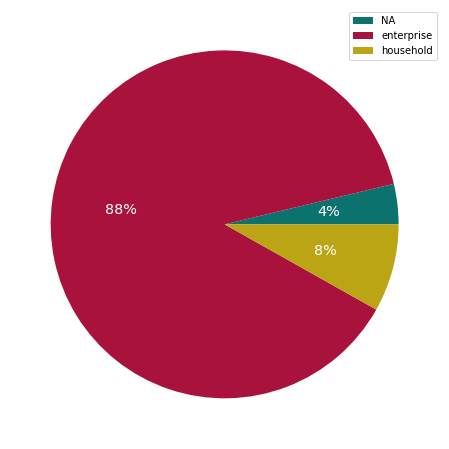

In [3]:
import pandas as pd
import numpy as np
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'/home/trang/working/projects/Machine-Learning/data_scrapping/')
from constants import tiki_information

conn = psycopg2.connect(tiki_information.db_connection)

cur = conn.cursor()
cur.execute('''with recursive category_tree (category_id, category_name, level, is_leaf) as (
                    select category_id, category_name, 0 as level, 0 as is_leaf
                    from categories
                    where category_id = 1846

                    union all

                    select c.category_id, c.category_name, ct.level+1 as level, case when not exists 
                    (select 1 from categories where parent_id = c.category_id) then 1 else 0 end as is_leaf
                    from categories c 
                        join category_tree ct on c.parent_id = ct.category_id
                )
                select distinct s.supplier_id, s.supplier_name, s.supplier_extra_information, p.product_id, p.title, spm.product_extra_information
                from suppliers s
                    join supplier_product_mapping spm on spm.supplier_id = s.supplier_id
                    join products p on p.product_id = spm.product_id
                    join category_product_detail cpd on cpd.product_id = p.product_id
                    join category_tree c on c.category_id = cpd.category_id and c.is_leaf = 1;''')
suppliers = cur.fetchall()

# Transform data
c_suppliers = pd.DataFrame(suppliers, columns = ['supplier_id', 'supplier_name', 'extra_information', 'product_id', 'product_name', 'product_extra_information'])
c_suppliers['business_type'] = c_suppliers['extra_information'].apply(lambda x: x['business_type'])
c_suppliers.loc[c_suppliers['business_type'].isna(),'business_type'] = 'NA'
business_type_summary = c_suppliers.groupby('business_type').count()['supplier_id']

# Draw chart
plt.figure(figsize=(8,8))
patches, texts, autotexts = plt.pie(business_type_summary, colors = ['#0C726E', '#A9123D', '#BCA514'], autopct='%.0f%%')
plt.legend(business_type_summary.index.values)

for text in autotexts:
    text.set_color('white')
    text.set_fontsize('x-large')

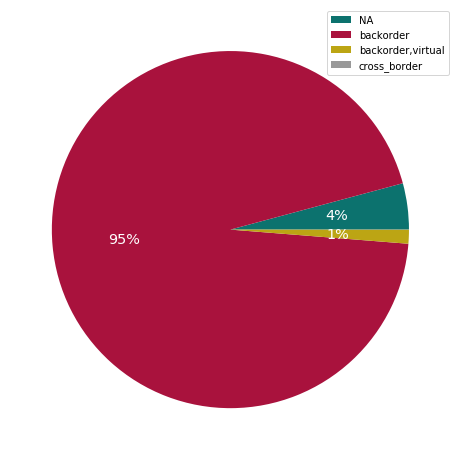

In [59]:
# Transform data
c_suppliers['inventory_type'] = c_suppliers['extra_information'].apply(lambda x:x['inventory_type'])
c_suppliers.loc[c_suppliers['inventory_type'].isna(),'inventory_type'] = 'NA'
c_suppliers.loc[c_suppliers['inventory_type'] == '','inventory_type'] = 'NA'
inventory_summary = c_suppliers.groupby('inventory_type').count()['supplier_id']

# Draw chart
plt.figure(figsize=(8,9))
patches, texts, autotexts = plt.pie(inventory_summary, colors = ['#0C726E', '#A9123D', '#BCA514', '#999999'], autopct = '%.0f%%')
plt.legend(inventory_summary.index.values)

for text in autotexts:
    text.set_color('white')
    text.set_fontsize('x-large')
autotexts[3].set_visible(False)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

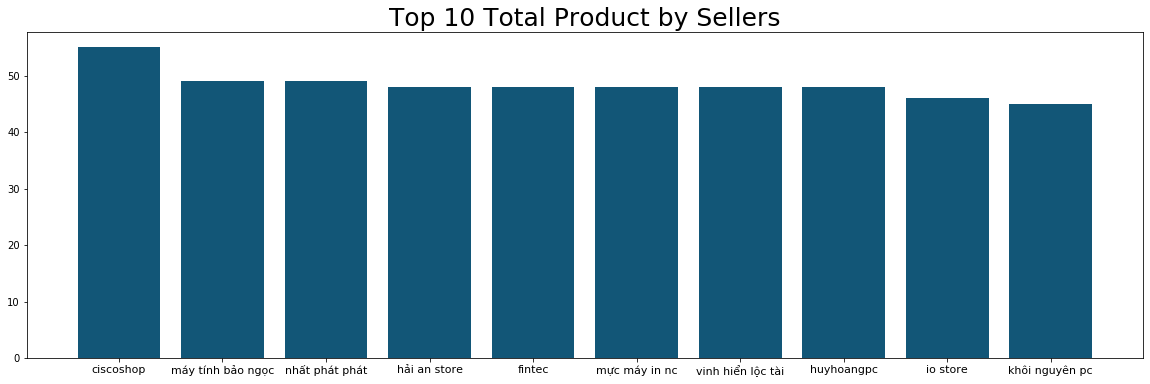

In [76]:
number_of_products_by_sup = c_suppliers.groupby('supplier_name').count().sort_values(by='supplier_id', ascending=False)['supplier_id']
top_10_sup = number_of_products_by_sup.head(10)

plt.figure(figsize=(20,6))
plt.bar(top_10_sup.index.values, top_10_sup, orientation='vertical', color='#125677')
title = plt.title('Top 10 Total Product by Sellers', fontsize=25)
plt.xticks(fontsize=11)

In [7]:
is_gift_card = c_suppliers['product_extra_information'].apply(lambda x:x['is_gift_card'])
products = c_suppliers[~is_gift_card]
girf_cards = c_suppliers[is_gift_card]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

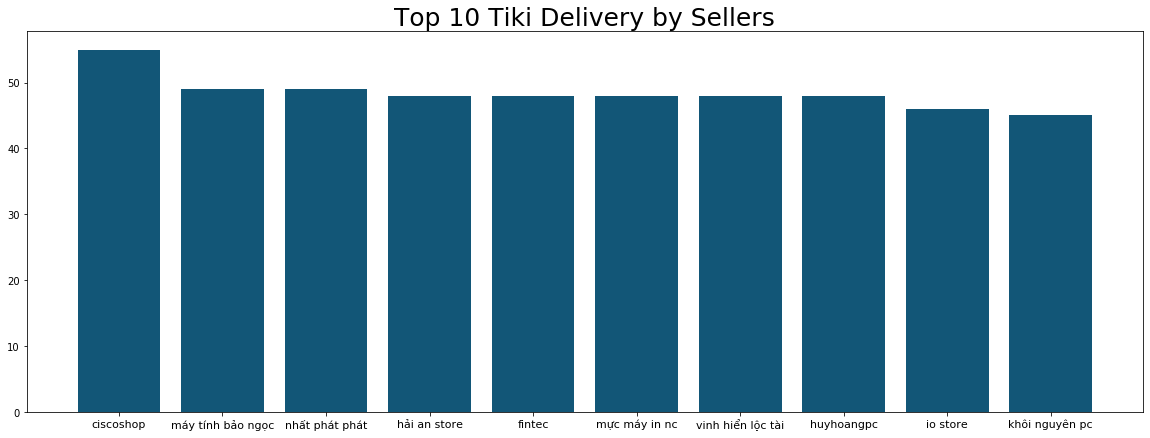

In [75]:
products['delivery'] = products['product_extra_information'].apply(lambda x: x['inventory']['fulfillment_type'] if 'fulfillment_type' in x['inventory'].keys() else 'NA')
top_10_delivery = products[products['delivery'] != 'NA'].groupby(['supplier_name', 'delivery']).count().sort_values(by='supplier_id', ascending=False)['supplier_id'].head(10)
top_10_delivery = top_10_delivery.reset_index()
top_10_delivery
plt.figure(figsize=(20,7))
plt.bar(top_10_delivery['supplier_name'], top_10_delivery['supplier_id'], orientation='vertical', color='#125677')
title = plt.title('Top 10 Tiki Delivery by Sellers', fontsize=25)
plt.xticks(fontsize=11)

In [9]:
top_10_other_delivery = products[products['delivery'] == 'NA'].groupby(['supplier_name', 'delivery']).count().sort_values(by='supplier_id', ascending=False)['supplier_id'].head(10)
top_10_other_delivery

supplier_name       delivery
thp vn              NA          2
công nghệ kiến hân  NA          1
Name: supplier_id, dtype: int64